In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from typing import Union, Optional
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv(
    './datasets/transaction_dataset.csv',
).drop(columns=['Unnamed: 0'])
df.head(10)

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
5,6,0x000895ad78f4403ecd9468900e68d6ee506136fd,0,9900.12,375.48,20926.68,2,3,0,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
6,7,0x000d63fc5df52b0204374c2f5a3249779805d5d1,0,69.46,629.44,8660.35,25,11,0,9,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
7,8,0x000e001ab444fa8d6dc4a402f8d7cfc88fe8c64d,0,1497.39,176.84,319828.05,213,5,0,3,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,7.0,NaN,XENON
8,9,0x0012cb699c836049a4bbeaac2d8c4d47c688e0e4,0,0.00,0.00,496.62,1,1,0,1,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
9,10,0x0012f247c9f980eea0a9ad06893bfd95c3145794,0,2570.59,3336.01,30572.70,8,3,0,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,NaN,AICRYPTO


In [3]:
df.shape


(9841, 50)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   Address                                               9841 non-null   object 
 2   FLAG                                                  9841 non-null   int64  
 3   Avg min between sent tnx                              9841 non-null   float64
 4   Avg min between received tnx                          9841 non-null   float64
 5   Time Diff between first and last (Mins)               9841 non-null   float64
 6   Sent tnx                                              9841 non-null   int64  
 7   Received Tnx                                          9841 non-null   int64  
 8   Number of Created Contracts                           9841

In [5]:
df["Unique Received From Addresses"]

0       40
1        5
2       10
3        7
4        7
        ..
9836    11
9837     0
9838    31
9839     1
9840     1
Name: Unique Received From Addresses, Length: 9841, dtype: int64

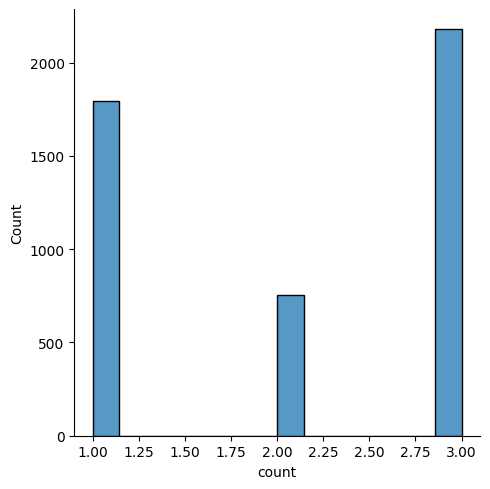

In [6]:
sns.displot(df['Index'].value_counts())
plt.show()

In [7]:
df_index_check = df.merge(
    df[['Index', 'Address']].groupby('Index').count().rename(columns={'Address': 'Index_count'}).reset_index(),
    on='Index'
)
df_index_check[df_index_check['Index_count'] > 1].head(10)

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type,Index_count
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire,3
1,1,0x4c13f6966dc24c92489344f0fd6f0e61f3489b84,0,5980.35,18633.46,498256.47,21,20,0,2,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,3
2,1,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31,34.12,4815.43,3,13,0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token,3
4,2,0x4c1da8781f6ca312bc11217b3f61e5dfdf428de1,0,7042.64,2694.86,80594.87,8,9,0,8,...,1.401027e+02,140.102687,0.0,0.0,0.0,1.0,2.0,Golem,OmiseGO,3
5,2,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50,834.77,9622.53,2,2,0,1,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,3
6,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON,3
7,3,0x4c24af967901ec87a6644eb1ef42b680f58e67f5,0,3098.05,4755.44,382590.08,36,57,0,2,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,3.0,NaN,VIU,3
8,3,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90,31.87,321.42,2,3,0,3,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,3
9,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON,3


In [8]:
df.drop(columns=['Index']).drop_duplicates().shape[0]


9823

In [9]:
df.shape[0]


9841

In [10]:
assert df.shape[0] == df.drop_duplicates().shape[0]
df = df.drop(columns='Index').drop_duplicates()

In [11]:
df.describe()


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9823.000000,9823.000000,9823.000000,9.823000e+03,9823.000000,9823.000000,9823.000000,9823.000000,9823.000000,9823.000000,...,8.994000e+03,8.994000e+03,8.994000e+03,8.994000e+03,8.994000e+03,8994.0,8994.0,8994.0,8994.000000,8994.000000
mean,0.221826,5092.595652,8011.602499,2.184347e+05,116.074417,163.972106,3.736537,30.406495,25.868472,43.785903,...,1.255029e+08,4.354898e+06,1.176474e+04,1.306006e+07,6.331012e+06,0.0,0.0,0.0,1.381588,4.824772
std,0.415496,21505.395360,23097.130771,3.229212e+05,757.890300,941.675903,141.575042,298.892226,264.058187,326.137833,...,1.054795e+10,2.143333e+08,1.054621e+06,1.181085e+09,5.920680e+08,0.0,0.0,0.0,6.720471,16.670650
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.171250e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,513.420000,4.695758e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095006,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,564.305000,5494.510000,3.041145e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,...,9.900000e+01,2.950601e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [12]:
zero_feature_list = df.columns[(df.nunique() == 1)].tolist()
zero_feature_list

[' ERC20 avg time between sent tnx',
 ' ERC20 avg time between rec tnx',
 ' ERC20 avg time between rec 2 tnx',
 ' ERC20 avg time between contract tnx',
 ' ERC20 min val sent contract',
 ' ERC20 max val sent contract',
 ' ERC20 avg val sent contract']

In [13]:
feature_list = list(set(df.columns) - set(['Address', 'FLAG']) - set(zero_feature_list)) # 49  - 2 - 7 = 40
print(len(set(df.columns)),len(set(['Address', 'FLAG'])),len(set(zero_feature_list)))

num_feature_list = list(set(feature_list) - set(df.dtypes[df.dtypes == 'object'].index) - set(zero_feature_list)) # 40 - 2  -0 = 38
print(len(set(feature_list)), len(set(df.dtypes[df.dtypes == 'object'].index)), len(set(zero_feature_list)))

cat_feature_list = list(set(feature_list) - set(num_feature_list)) # 40 - 38 = 2
print(len(set(feature_list)), len(set(num_feature_list)))

assert len(feature_list) == len(num_feature_list) + len(cat_feature_list) # 38+0=38
len(num_feature_list)

49 2 7
40 3 7
40 38


38

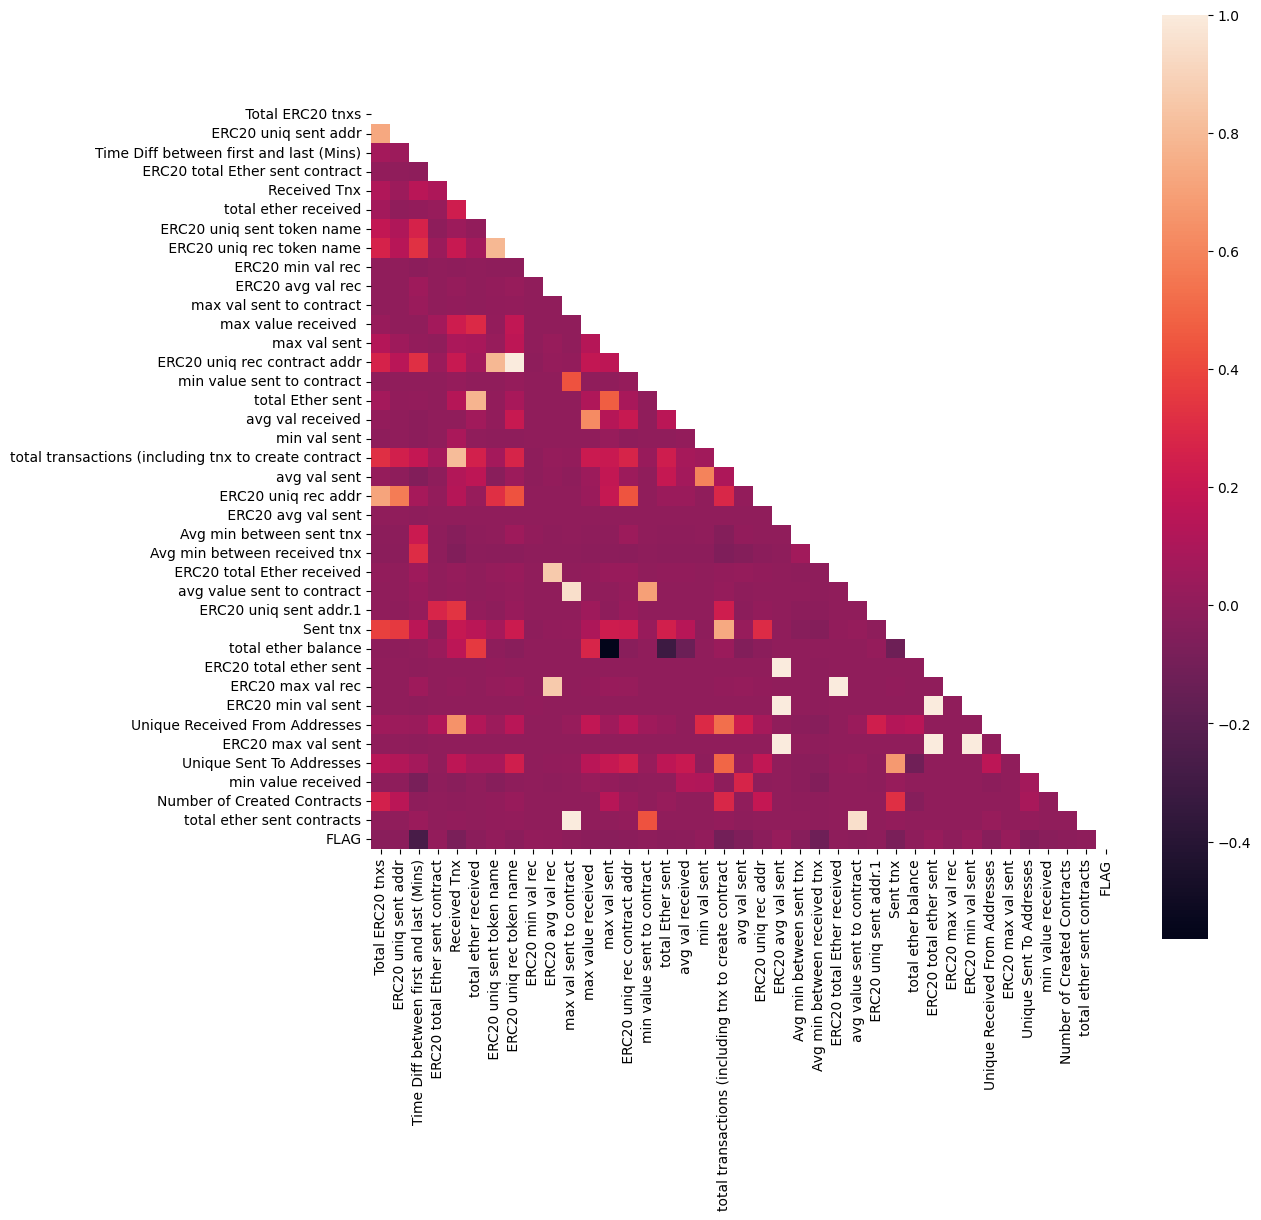

In [14]:
corr = df[num_feature_list + ['FLAG']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12, 12))
sns.heatmap(data=corr, mask=mask, square=True)
plt.show()

In [15]:
df[num_feature_list + ['FLAG']].corr()[['FLAG']]


,FLAG
Total ERC20 tnxs,-0.025737
ERC20 uniq sent addr,-0.020593
Time Diff between first and last (Mins),-0.269853
ERC20 total Ether sent contract,0.013501
Received Tnx,-0.079493
total ether received,-0.016934
ERC20 uniq sent token name,0.009490
ERC20 uniq rec token name,-0.018029
ERC20 min val rec,0.011143
ERC20 avg val rec,0.007866


In [16]:
pairs = df[num_feature_list].corr().stack()
pairs_list = list(pairs[pairs.abs().gt(0.9) & pairs.abs().lt(1.0)].index)
print(int(len(pairs_list) / 2))

11


In [17]:
uniq_pairs_list = []

for x, y in pairs_list:
    if (x, y) in uniq_pairs_list or (y, x) in uniq_pairs_list:
        continue
    else:
        uniq_pairs_list.append((x, y))

In [18]:
filter_cor_feature_list =  list({x[0] for x in uniq_pairs_list})
filter_cor_feature_list

[' ERC20 total ether sent',
 'max val sent to contract',
 ' ERC20 avg val sent',
 ' ERC20 min val sent',
 ' ERC20 total Ether received',
 ' ERC20 uniq rec token name',
 'avg value sent to contract']

In [19]:
len(list(set(num_feature_list) - set(filter_cor_feature_list)))


31

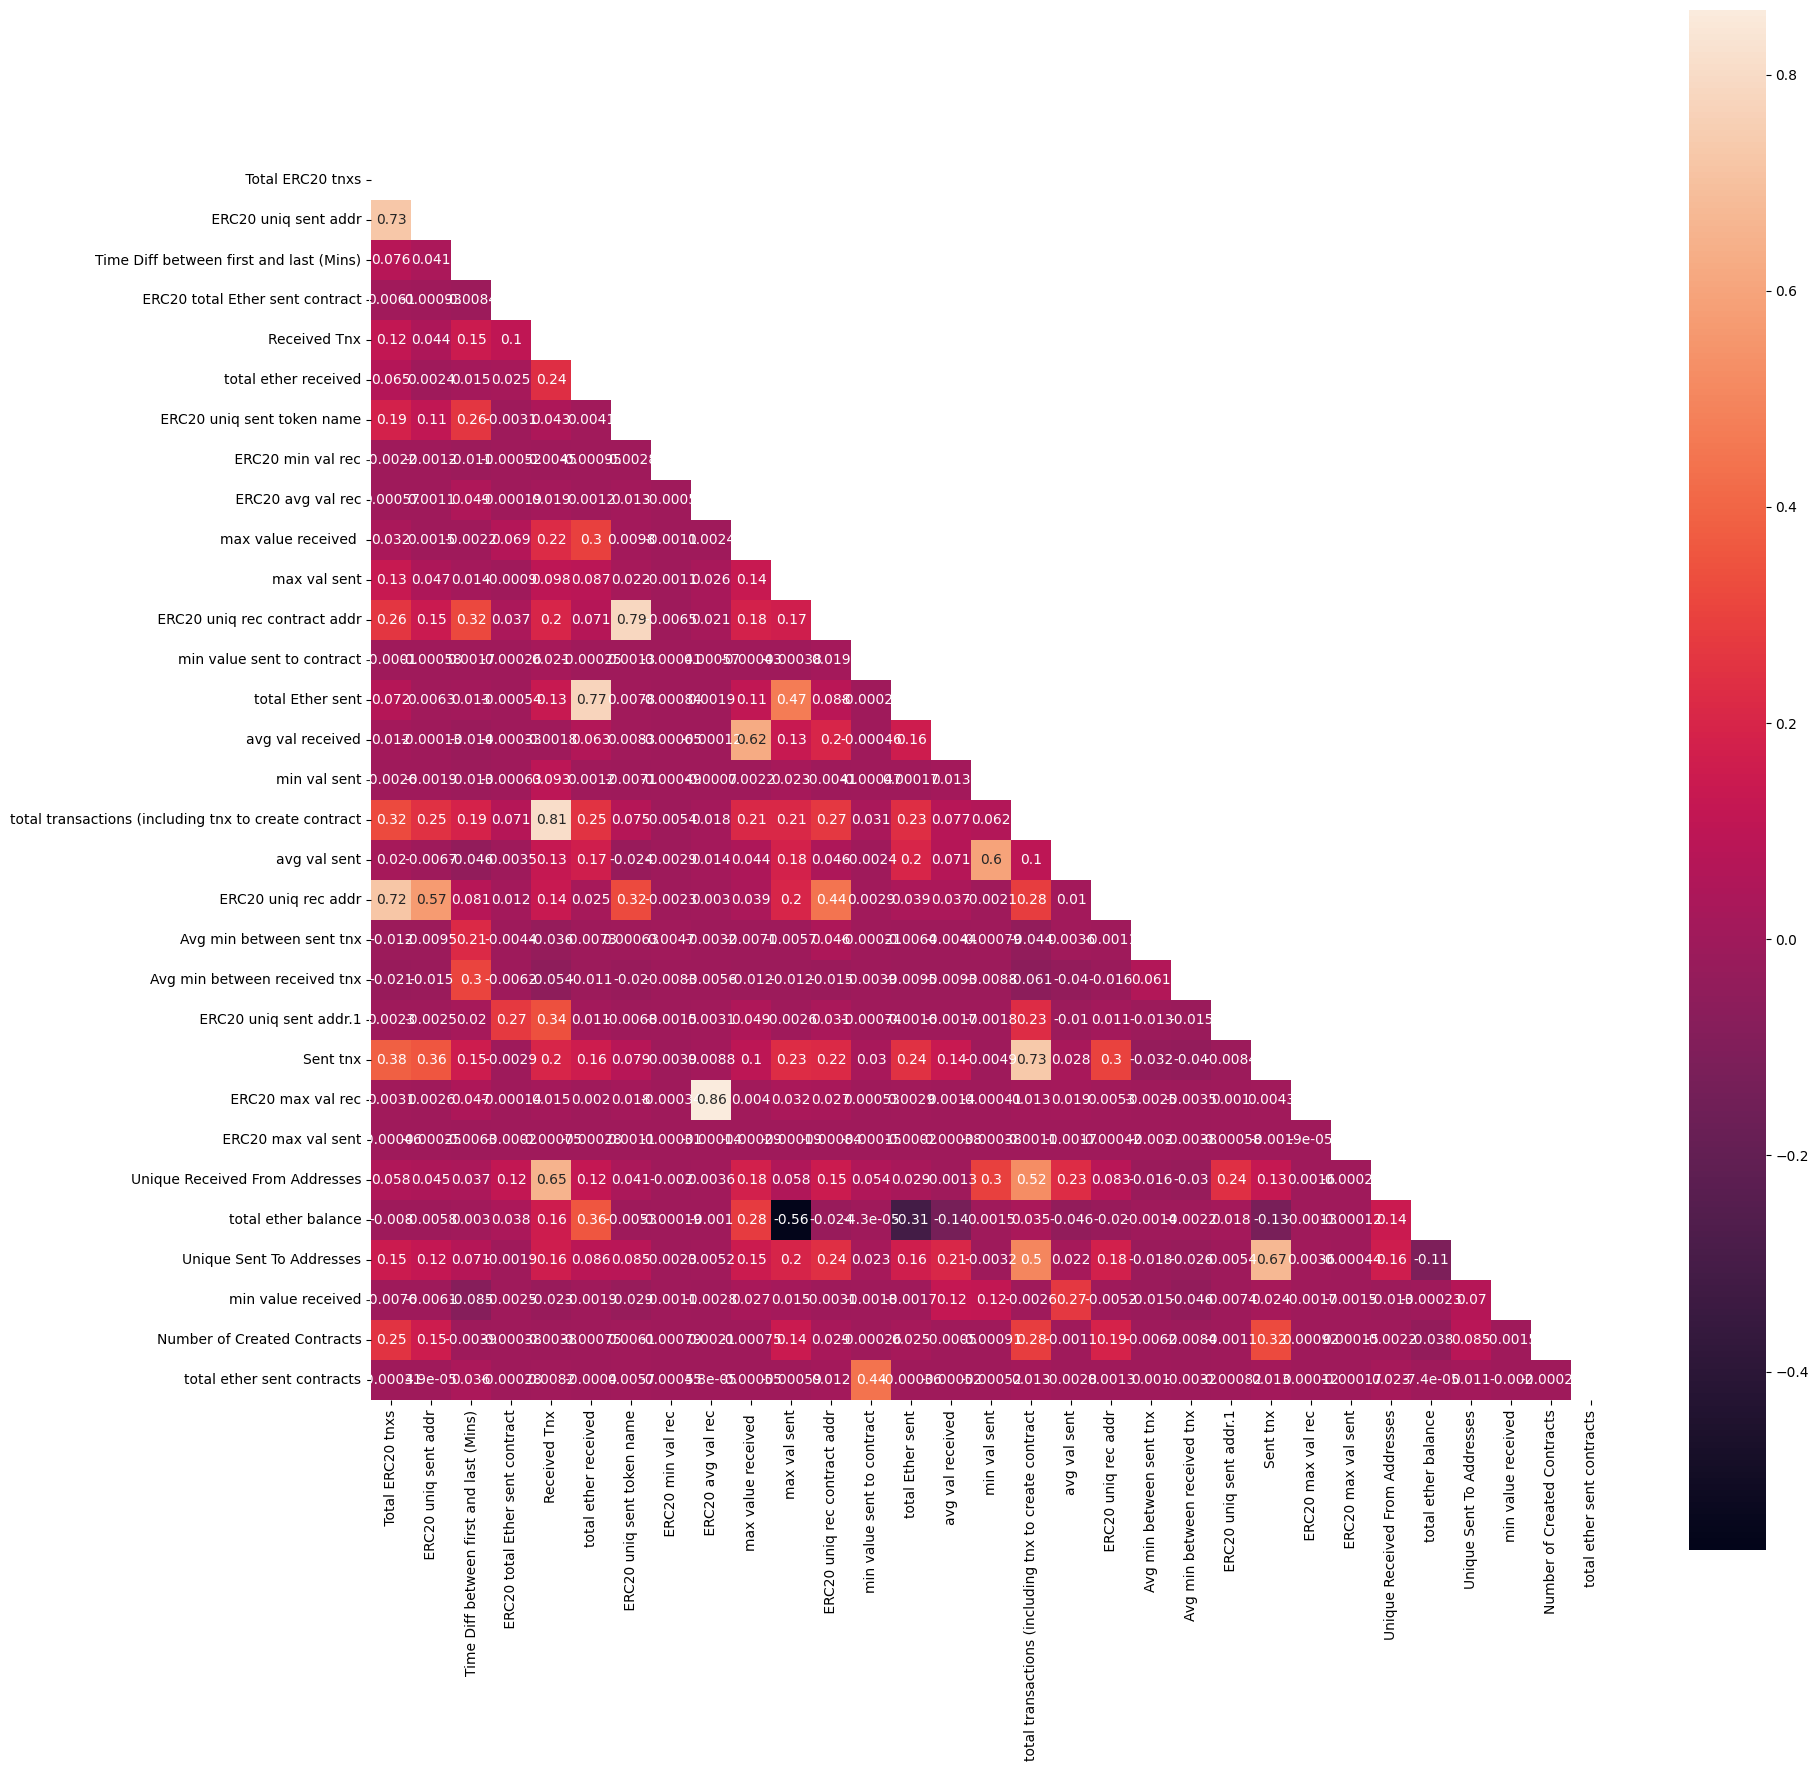

In [20]:
# матрица корреляции после чистки 

corr = df[list(set(num_feature_list) - set(filter_cor_feature_list))].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(20, 20))
sns.heatmap(data=corr, mask=mask, square=True, annot=True)
plt.show()

In [21]:
for feature in cat_feature_list:
    df.loc[df[feature].isin([' ', '0']), feature] = 'None'

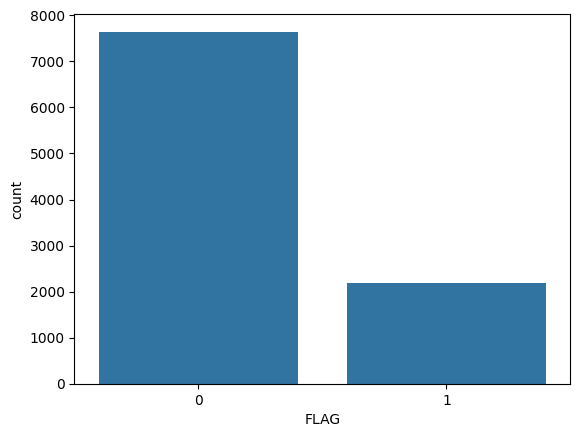

Target:  0.22182632596966304


In [22]:
sns.countplot(data=df, x='FLAG')
plt.show()
print('Target: ', df['FLAG'].mean())

In [23]:
# train - test split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=0, stratify=df['FLAG'])
df_train.shape[0], df_test.shape[0]
df_test

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
903,0x16402006acad6447a2f470fe24ce1090b488614a,0,6.01,0.00,372.85,62,2,0,2,62,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,None,None
1472,0x258b96cea13cf08a8bc2b4eda60cee13aab101f3,0,2.11,0.52,7.35,3,2,0,2,3,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,None,None
4277,0x7196912d83e2c847ff9817d83d514ce75afb9f6f,0,0.00,0.00,0.00,0,1,0,1,0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5.0,NaN,Livepeer Token
2335,0x3cca17c852a99f30a6bb29e8a956d7bbfe69b6db,0,0.00,1926.03,192603.17,0,100,1,3,0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,NaN,OmiseGO
7828,0x117262defa4ece46a009e5e883d7c6f9d2d69b89,1,982.61,120999.23,608926.62,4,5,0,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,0x62ad16f9ef5656a967b1b70cc5475c7cd23aea0b,0,3156.16,10610.49,304070.98,56,12,0,11,14,...,0.0,1767.053864,638.561477,0.0,0.0,0.0,5.0,6.0,ZRX,ZRX
7446,0xc86ed0814e5dc8638ce8ea6a626177e35b7b959b,0,0.00,4611.09,161388.02,0,35,1,6,0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,NaN,OmiseGO
8378,0x4fafc9291a0112a0ee0928361c02848ff2fdf6bd,1,0.00,4.60,68288.75,1,5,0,4,1,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,None,Livepeer Token
6616,0xb07b1663498b681c1744ae40d89b34e45df4d296,0,34.72,1113.58,8038.07,7,7,0,4,7,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,None,None


In [24]:

# train - valid split

df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=0, stratify=df_train['FLAG'])
df_train.shape[0], df_valid.shape[0]

(7956, 884)

In [25]:
df_train['FLAG'].mean(), df_valid['FLAG'].mean(), df_test['FLAG'].mean()


(0.22184514831573654, 0.22171945701357465, 0.22177009155645983)

In [26]:
class DataPrep(BaseEstimator, TransformerMixin):
    """Implementation preprocess dataset in several strategies"""
    
    def __init__(self, num_feature_list: list, cat_feature_list: list, drop_feature_list: Optional[list] = None,
                 cat_encoder_type: Union[str, list] = 'label', cat_min_count: int = 10,
                 fillna: Union[int, str] = 0, q_up_clip_outliers: Optional[float] = None,
                 q_down_clip_outliers: Optional[float] = None, build_feature=False):
        """
            `num_feature_list` - list with num features name
            `cat_feature_list` - list with cat features name
            `cat_encoder_type` - use `dummy` or `label` or both methods to encode features
            `drop_feature_list` - features to drop
            `cat_min_count` - min count to separete category from `other` category
            `fillna` - fill nans with 0, `mean` or `median` feature value
            `q_up_clip_outliers` - up quantile to clip outliers
            `q_down_clip_outliers` - down quantile to clip outliers
            `build_feature` - build new feature flag
        """
        self.cat_feature_list = cat_feature_list
        self.num_feature_list = num_feature_list
        self.cat_encoder_type = cat_encoder_type
        self.drop_feature_list = drop_feature_list
        self.cat_min_count = 50
        self.fillna = fillna
        self.q_up_clip_outliers = q_up_clip_outliers
        self.q_down_clip_outliers = q_down_clip_outliers
        self.build_feature = build_feature
        
        
    def fit(self, df):
        self.num_fillna_dict = {}
        self.num_q_up_dict = {}
        self.num_q_down_dict = {}
        self.cat_emb_dict = {}
        
        # numerical fillna fit
        if self.fillna == 'median':
            for feature in self.num_feature_list:
                self.num_fillna_dict[feature] = df[feature].median()
        elif self.fillna == 'mean':
            for feature in self.num_feature_list:
                self.num_fillna_dict[feature] = df[feature].mean()
        elif self.fillna == 0:
            for feature in self.num_feature_list:
                self.num_fillna_dict[feature] = 0                
        else:
            for feature in self.num_feature_list:
                self.num_fillna_dict[feature] = None
            
        # numerical outliers fit
        if self.q_up_clip_outliers:
            for feature in self.num_feature_list:
                self.num_q_up_dict[feature] = df[feature].quantile(self.q_up_clip_outliers)
                
        if self.q_down_clip_outliers:
            for feature in self.num_feature_list:
                self.num_q_down_dict[feature] = df[feature].quantile(self.q_down_clip_outliers)
            
        # cat fit
        for feature in self.cat_feature_list:
            cat_series = df[feature].value_counts()
            cat_series[cat_series.lt(self.cat_min_count)] = 1
            self.cat_emb_dict[feature] = cat_series.to_dict()
            
        if self.drop_feature_list:
            self.num_feature_list = list(set(self.num_feature_list) - set(self.drop_feature_list))
            self.cat_feature_list = list(set(self.cat_feature_list) - set(self.drop_feature_list))
            
        return self
        
    def transform(self, df):
        check_is_fitted(self, attributes=['num_fillna_dict', 'cat_emb_dict'])
        
        # drop features
        if self.drop_feature_list:
            df = df.drop(columns=self.drop_feature_list)
        
        
        # numerical fillna
        for feature in self.num_feature_list:
            df.loc[df[feature].isna(), feature] = self.num_fillna_dict[feature]
        
        
        # numerical outliers
        if self.q_up_clip_outliers:
            for feature in self.num_feature_list:
                df.loc[df[feature] > self.num_q_up_dict[feature], feature] = self.num_q_up_dict[feature]
                
        if self.q_down_clip_outliers:
            for feature in self.num_feature_list:
                df.loc[df[feature] < self.num_q_down_dict[feature], feature] = self.num_q_down_dict[feature]
        
        
        # categorical embed
        df[self.cat_feature_list] = df[self.cat_feature_list].fillna('None') 
        for feature in self.cat_feature_list:
            df[feature] = df[feature].map(self.cat_emb_dict[feature]).fillna(1)
            
        cat_encoder_type_list = self.cat_encoder_type if isinstance(self.cat_encoder_type, list) else [self.cat_encoder_type]
        
        if 'dummy' in cat_encoder_type_list:
            for feature in self.cat_feature_list:
                df_dummy = pd.get_dummies(df[feature], prefix=feature)
                df = df.merge(df_dummy, left_index=True, right_index=True)
                
        if 'label' not in cat_encoder_type_list:
            df = df.drop(columns=self.cat_feature_list)
            
        # feature engineering example
        if self.build_feature:
            df['total_Ether_ratio'] = df['total Ether sent'] / (df['total ether received'] + 1)
            df['total_Ether_ratio_v2'] = (df['total Ether sent'] - df['total ether received']) / (df['total Ether sent'] + df['total ether received'] + 1)
            
            df['ERC20_uniq_addr_ratio'] = df[' ERC20 uniq sent addr'] / (df[' ERC20 uniq rec addr'] + 1)
            df['ERC20_uniq_addr_ratio_v2'] = (df[' ERC20 uniq sent addr'] - df[' ERC20 uniq rec addr']) / (df[' ERC20 uniq sent addr'] + df[' ERC20 uniq rec addr'] + 1)
        
        return df

In [27]:
dp = DataPrep(
    num_feature_list=num_feature_list,
    cat_feature_list=cat_feature_list,
    cat_encoder_type=None,
    cat_min_count=10,
    fillna='median',
)

In [28]:
df_train_prep = dp.fit_transform(df_train)
df_valid_prep = dp.transform(df_valid)
df_test_prep = dp.transform(df_test)
df_test_prep

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
903,0x16402006acad6447a2f470fe24ce1090b488614a,0,6.01,0.00,372.85,62,2,0,2,62,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1472,0x258b96cea13cf08a8bc2b4eda60cee13aab101f3,0,2.11,0.52,7.35,3,2,0,2,3,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4277,0x7196912d83e2c847ff9817d83d514ce75afb9f6f,0,0.00,0.00,0.00,0,1,0,1,0,...,52.906561,11.813373,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5.0
2335,0x3cca17c852a99f30a6bb29e8a956d7bbfe69b6db,0,0.00,1926.03,192603.17,0,100,1,3,0,...,0.397976,0.397976,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
7828,0x117262defa4ece46a009e5e883d7c6f9d2d69b89,1,982.61,120999.23,608926.62,4,5,0,5,2,...,0.000000,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,0x62ad16f9ef5656a967b1b70cc5475c7cd23aea0b,0,3156.16,10610.49,304070.98,56,12,0,11,14,...,1264.781461,479.038838,0.0,1767.053864,638.561477,0.0,0.0,0.0,5.0,6.0
7446,0xc86ed0814e5dc8638ce8ea6a626177e35b7b959b,0,0.00,4611.09,161388.02,0,35,1,6,0,...,0.324884,0.324884,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
8378,0x4fafc9291a0112a0ee0928361c02848ff2fdf6bd,1,0.00,4.60,68288.75,1,5,0,4,1,...,2.174620,2.174620,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
6616,0xb07b1663498b681c1744ae40d89b34e45df4d296,0,34.72,1113.58,8038.07,7,7,0,4,7,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [29]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[num_feature_list])
df_valid_prep = scaler.transform(df_valid_prep[num_feature_list])
df_test_prep = scaler.transform(df_test_prep[num_feature_list])
df_test_prep

array([[-0.08089738, -0.05414504, -0.67530688, ..., 12.66807616,
        -0.03010168, -0.01665913],
       [-0.08089738, -0.05414504, -0.67643448, ...,  1.00230453,
        -0.03010168, -0.01665913],
       [-0.07008315, -0.05414504, -0.67645716, ..., -0.13342775,
        -0.03010168, -0.01665913],
       ...,
       [-0.07873454, -0.05414504, -0.46578048, ..., -0.13391686,
        -0.03010168, -0.01665913],
       [-0.08089738, -0.05414504, -0.65165902, ..., -0.13372928,
        -0.03010168, -0.01665913],
       [-0.08089738, -0.05414504,  0.32372853, ..., -0.13366877,
        -0.03010168, -0.01665913]])

In [30]:
df_test_prep.shape

(983, 38)

In [31]:
len(num_feature_list)

38

Logistic Regression¶


LGBMClassifier¶


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1765, number of negative: 6191
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6701
[LightGBM] [Info] Number of data points in the train set: 7956, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221845 -> initscore=-1.254946
[LightGBM] [Info] Start training from score -1.254946
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.0373697
903     0
1472    0
4277    0
2335    0
7828    1
       ..
3713    0
7446    0
8378    1
6616    0
7116    0
Name: FLAG, Length: 983, dtype: int64 [4.02197835e-04 4.02197835e-04 1.85485152e-02 8.88097443e-04
 9.8

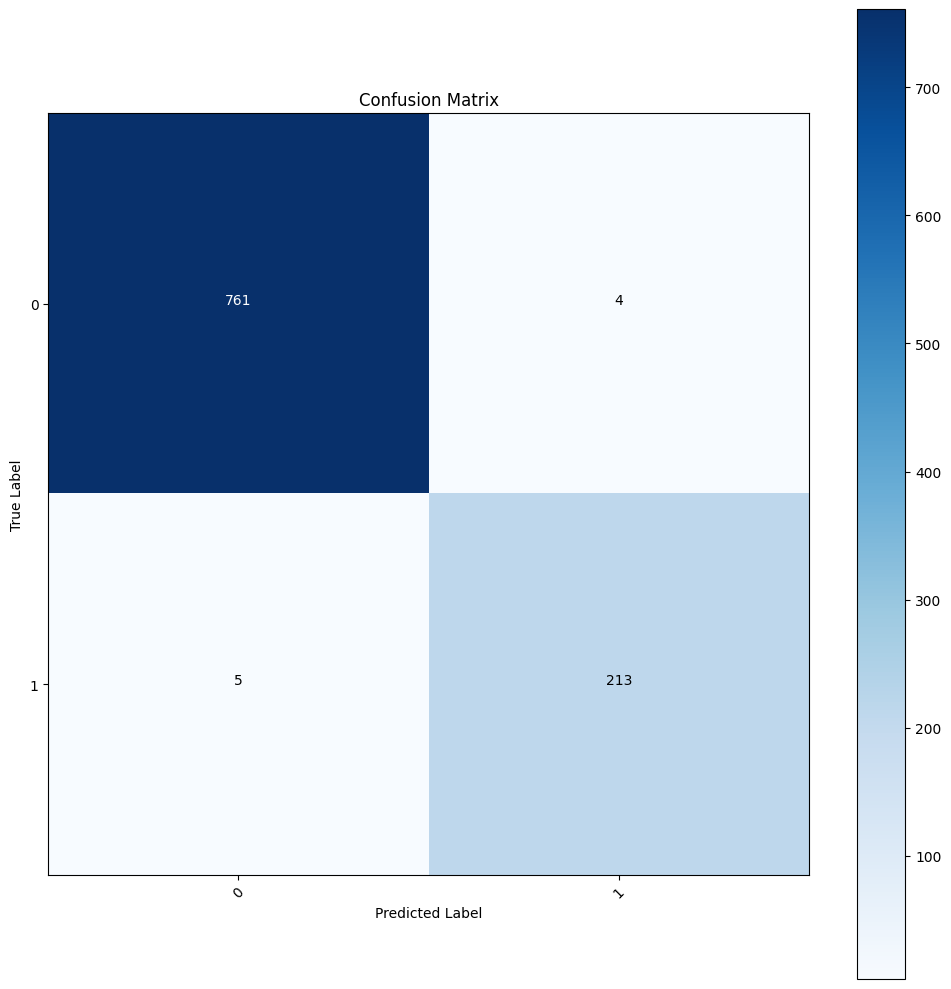

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       765
           1       0.98      0.98      0.98       218

    accuracy                           0.99       983
   macro avg       0.99      0.99      0.99       983
weighted avg       0.99      0.99      0.99       983



In [32]:
# 训练模型
import itertools

model = LGBMClassifier(
    n_estimators=1000,
    random_state=0
)
model.fit(
    X=df_train[num_feature_list],
    y=df_train['FLAG'],
    eval_set=[(df_valid[num_feature_list], df_valid['FLAG'])],
    eval_metric='roc_auc',
    callbacks=[early_stopping(5)]
)
y_test_true, y_test_pred = df_test['FLAG'], model.predict_proba(df_test[num_feature_list])[:, 1]
print(y_test_true,y_test_pred)
print('train roc_auc_score: ', roc_auc_score(df_train['FLAG'], model.predict_proba(df_train[num_feature_list])[:, 1]))
print('valid roc_auc_score: ', roc_auc_score(df_valid['FLAG'], model.predict_proba(df_valid[num_feature_list])[:, 1]))
print('test roc_auc_score: ', roc_auc_score(y_test_true, y_test_pred))

# 生成混淆矩阵
classes = list(set(y_test_true.values))
y_test_pred_class = model.predict(df_test[num_feature_list])
cm = confusion_matrix(y_test_true, y_test_pred_class)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 打印分类报告
print('Classification Report:')
print(classification_report(y_test_true, y_test_pred_class))

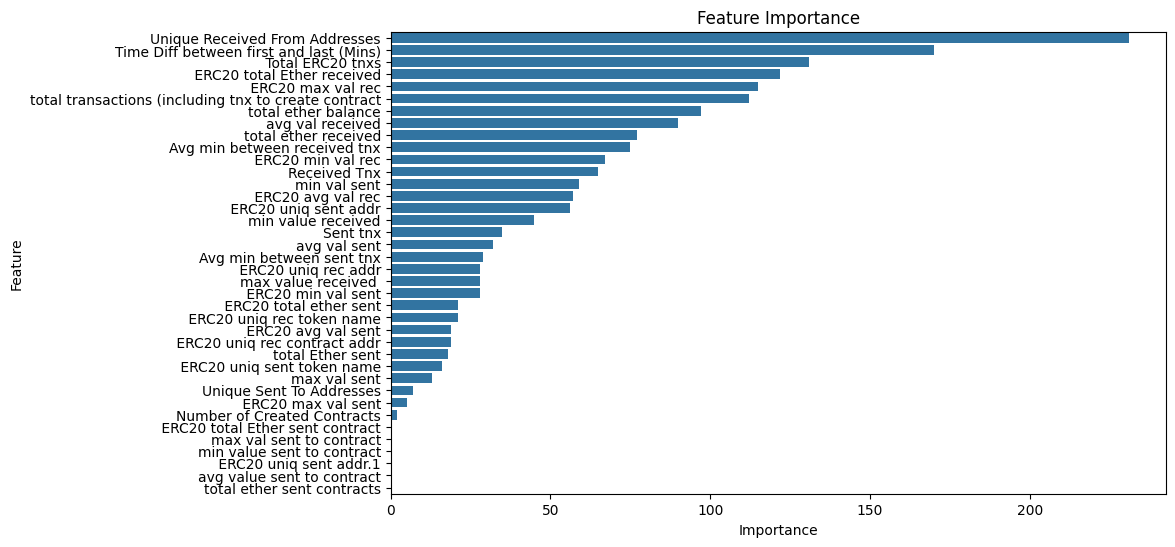

In [33]:
# 特征重要性分析
feature_importances = model.feature_importances_
feature_names = num_feature_list

# 创建特征重要性数据框
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 根据重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

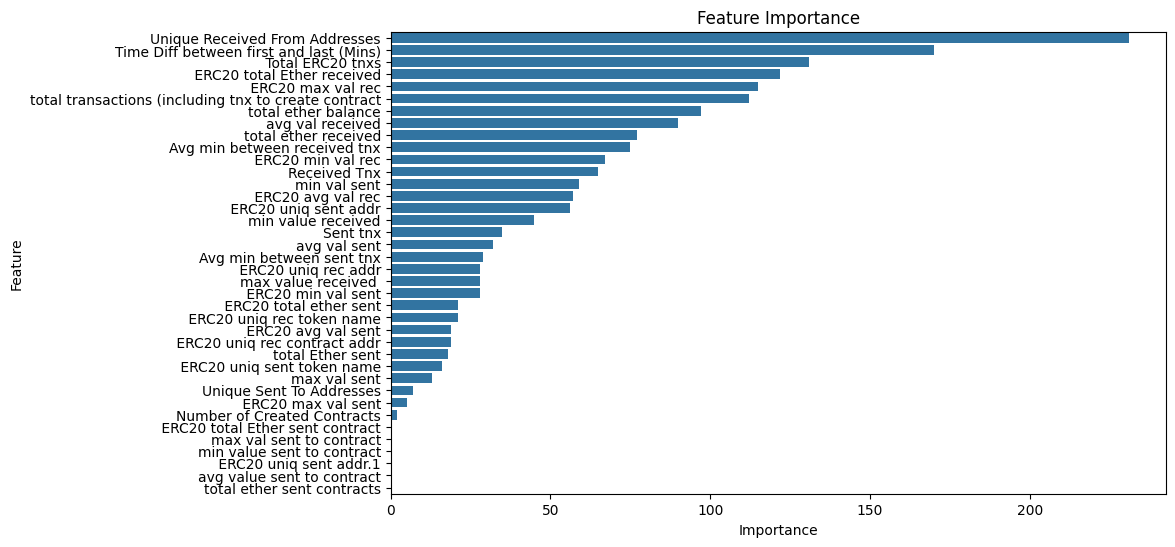

In [36]:
# 获取前五个特征和第六到第十个特征的索引
top_5_indices = feature_importance_df.index[:5]
next_5_indices = feature_importance_df.index[5:10]

# 保存它们的 Importance 值
top_5_importances = feature_importance_df.loc[top_5_indices, 'Importance'].values
next_5_importances = feature_importance_df.loc[next_5_indices, 'Importance'].values

# 交换它们的 Importance 值
feature_importance_df.loc[top_5_indices, 'Importance'] = next_5_importances
feature_importance_df.loc[next_5_indices, 'Importance'] = top_5_importances

# 重新排序并可视化
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()